In [3]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [4]:
import torch
torch.cuda.set_device(3)

In [5]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [6]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [8]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))



Aux function for splitting between training and testing


In [9]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [11]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def leaves(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def wood(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def pole(input, target):
    target = target.squeeze(1)
    mask = target != 3
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def grape(input, target):
    target = target.squeeze(1)
    mask = target != 4
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Early Stopping parameters

In [12]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=3

In [13]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [14]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [15]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=4
        mask[mask==150]=1
        mask[mask==76]=3
        mask[mask==74]=3
        mask[mask==29]=2
        mask[mask==25]=2
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [16]:
path_manual_img = path_images/'train'
path_manual_lbl = path_labels/'train'

dataset/Images/train/color_159.jpg


<AxesSubplot:>

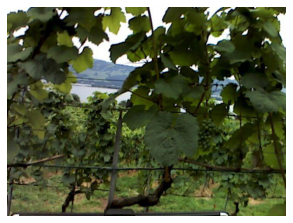

In [17]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [18]:
print(get_y_fn(img_f))

dataset/Labels/train/gt_159.png


<AxesSubplot:>

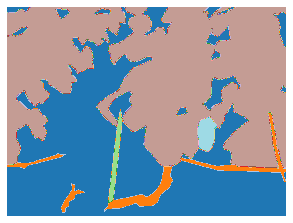

In [19]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [20]:
np.unique(np.array(mask))

array([  0,  29,  76, 150, 255], dtype=uint8)

In [22]:
def get_dls(bs = 4,size=(480,640)):
    manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize(size), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
    dls = manual.dataloaders(path_images,bs=bs)
    return dls

# 240x320

In [30]:
dls = get_dls(bs=8,size=(240,320))

In [31]:
learn = get_segmentation_learner(dls=dls, number_classes=5, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50",
                                 metrics=[background,leaves,pole,grape,wood,msa],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

Recorder

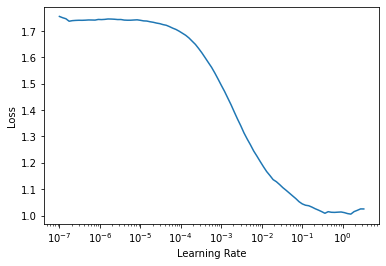

In [25]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,1.804272,1.628276,0.029967,0.025935,0.000000,0.014687,0.014792,0.014515,00:07
1,1.639194,1.546224,0.326001,0.220813,0.265508,0.275659,0.277618,0.272427,00:07
2,1.362753,1.216139,0.820506,0.495670,0.686878,0.684969,0.689824,0.676928,00:07
3,1.125702,1.013242,0.826659,0.601890,0.749301,0.747192,0.752109,0.738432,00:07
4,0.946419,0.839360,0.881263,0.469946,0.698361,0.695476,0.699496,0.688233,00:08
5,0.818084,0.731231,0.728985,0.680304,0.736665,0.730741,0.738708,0.727205,00:07
6,0.719462,0.555270,0.812926,0.714495,0.798032,0.789216,0.801937,0.787154,00:08
7,0.640871,0.540287,0.825391,0.722338,0.804733,0.795941,0.804564,0.793623,00:07
8,0.582080,0.467209,0.793867,0.786219,0.832839,0.830482,0.834391,0.821537,00:07
9,0.533759,0.645483,0.701927,0.732728,0.746245,0.736401,0.748813,0.737264,00:08


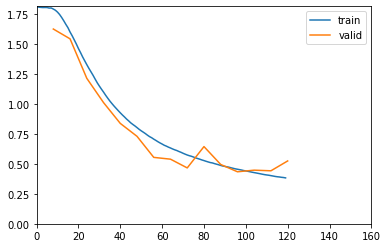

Better model found at epoch 0 with valid_loss value: 1.6282764673233032.
Better model found at epoch 1 with valid_loss value: 1.5462243556976318.
Better model found at epoch 2 with valid_loss value: 1.2161386013031006.
Better model found at epoch 3 with valid_loss value: 1.013242483139038.
Better model found at epoch 4 with valid_loss value: 0.839360237121582.
Better model found at epoch 5 with valid_loss value: 0.7312312126159668.
Better model found at epoch 6 with valid_loss value: 0.5552695989608765.
Better model found at epoch 7 with valid_loss value: 0.5402868390083313.
Better model found at epoch 8 with valid_loss value: 0.46720877289772034.
Better model found at epoch 11 with valid_loss value: 0.4348776936531067.
No improvement since epoch 11: early stopping


In [32]:
fname="deeplab-before-unfreeze"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

# 480x640

In [33]:
learn.dls = get_dls()

Recorder

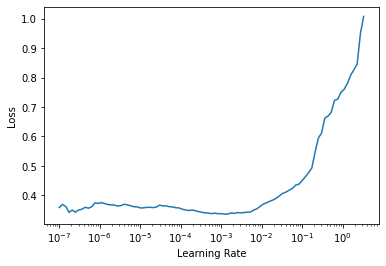

In [34]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [37]:
learn.load("deeplab-before-unfreeze")
learn.unfreeze()
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,0.370482,0.484927,0.820814,0.734730,0.804638,0.802392,0.806382,0.797164,00:10
1,0.371989,0.513301,0.837531,0.696941,0.790663,0.789452,0.792867,0.783934,00:09
2,0.376889,0.525429,0.844673,0.683734,0.786677,0.785041,0.788428,0.779778,00:10
3,0.372964,0.524053,0.838901,0.686765,0.786267,0.784873,0.788308,0.779335,00:10


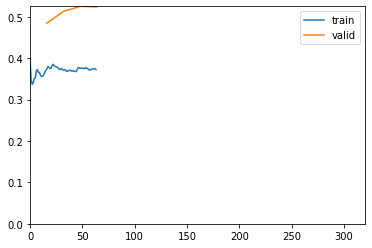

Better model found at epoch 0 with valid_loss value: 0.48492684960365295.
No improvement since epoch 0: early stopping


In [38]:
fname="deeplab-after-unfreeze"


callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

In [29]:
learn.validate()

(#7) [0.3805834949016571,0.8687860369682312,0.7991335988044739,0.8530165553092957,0.8525248169898987,0.857071578502655,0.8488269448280334]

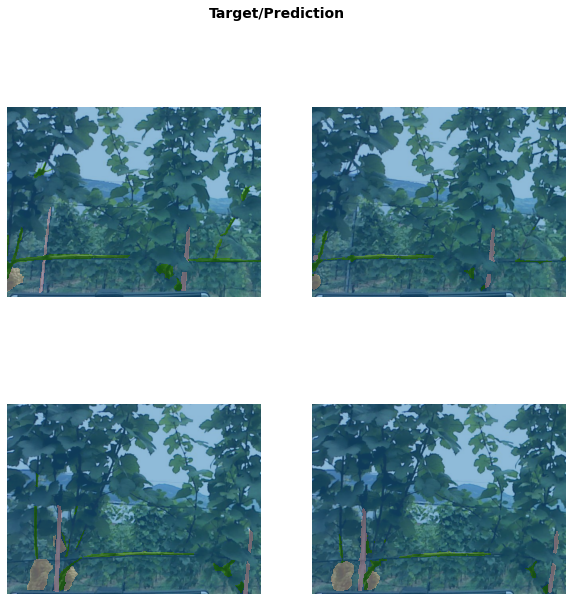

In [30]:
learn.show_results(figsize=(10,10))

In [31]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("deeplab.pth")

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# HRNet

model = torch.jit.load("deeplab.pth")
model = model.cpu()
model.eval()


RecursiveScriptModule(
  original_name=DeepLabV3Plus
  (backbone): RecursiveScriptModule(
    original_name=ResNetV1
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BottleneckV1b
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsample): RecursiveScriptModule(
          original_name=Sequential

In [33]:
import torchvision.transforms as transforms
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [53]:
image = Image.open('dataset/Images/test/color_154.jpg')

In [54]:
image = transforms.Resize((480,640))(image)
tensor = transform_image(image=image)

In [55]:
model.to(device)
with torch.no_grad():
    outputs = model(tensor)

outputs = torch.argmax(outputs,1)

In [56]:
mask = np.array(outputs.cpu())

In [57]:
mask[mask==4]=255
mask[mask==1]=150
mask[mask==3]=76
mask[mask==2]=29

In [58]:
mask=np.reshape(mask,(480,640))

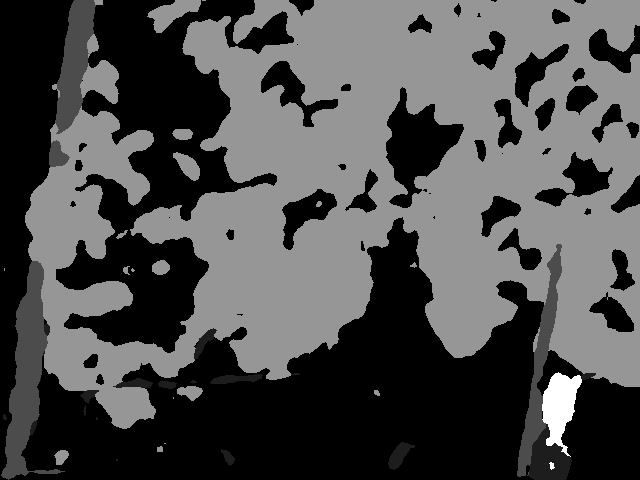

In [59]:
maskShow = Image.fromarray(mask.astype('uint8'))
maskShow

In [60]:
maskrgb = maskShow.convert('RGB')
maskrgb = np.array(maskrgb)
maskrgb[(maskrgb==[150,150,150]).all(axis=2)]=[0,255,0]
maskrgb[(maskrgb==[76,76,76]).all(axis=2)]=[255,0,0]
maskrgb[(maskrgb==[29,29,29]).all(axis=2)]=[0,0,255]

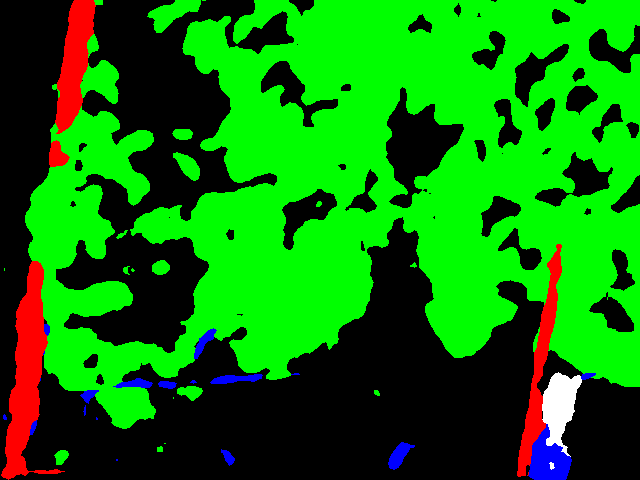

In [61]:
maskRGBShow = Image.fromarray(maskrgb.astype('uint8'))
maskRGBShow

In [43]:
maskRGBShow.save('deeplab_pred_155.jpg')